In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os

In [21]:
# sample signal for testing
# t = np.linspace(0, 1, 49)
# signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 150 * t)
# signal[400:600] += 2  # Add a step to make it more interesting


dir_path = '/Users/brolin/Documents/RWTH/terrain_property_prediction/src/terrain_classification/terrain_classification/data/sand/'
file_path = dir_path+'trial4.csv'
data = pd.read_csv(file_path)
# Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()
# Remove columns with 'time' in their name
data = data[data.columns.drop(list(data.filter(regex='time')))]

# Access the 'fl-z' column
# Convert 'fl-z' column to numeric, coercing errors to NaN
column_names = ['fl-z', 'fr-z', 'rl-z', 'rr-z', 'fl-contact', 'fr-contact', 'rl-contact', 'rr-contact']
for col in column_names:
    # Check if the column exists in the DataFrame
    if col in data.columns:
        # Convert the column to numeric, coercing errors to NaN
        data[col] = pd.to_numeric(data[col], errors='coerce')
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# Drop rows with NaN values in 'fl-z' column
test_data = 'fl-z'
test_contact = 'fl-contact'
data = data.dropna(subset=[test_data])

# Access the 'fl-z' column as a numpy array
fl_z = data[test_data].to_numpy()

# Round the values to 2 decimal places
fl_z = np.round(fl_z, 2)

#getting values only during contact
idx = np.where(data[test_contact] == 1)[0]
fl_z_contact = fl_z[idx]

In [32]:
print(type(fl_z_contact))

<class 'numpy.ndarray'>


In [22]:
leg = ['fl', 'fr']
component = ['x', 'z']
# name = f'{leg}-{component}'
names = [f'{leg}-{comp}' for leg in leg for comp in component]
contact_names = [f'{leg}-contact' for leg in leg]
# contact_name = f'{leg}-contact'
print(names)
print(contact_names)

['fl-x', 'fl-z', 'fr-x', 'fr-z']
['fl-contact', 'fr-contact']


In [ ]:
# data.dtypes
plt.plot(fl_z)
plt.title('Original Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# data.dtypes
plt.plot(fl_z_contact)
plt.title('Only contact signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

In [30]:
# Find indices where the values are non-zero
non_zero_indices = np.where(fl_z_contact != 0)[0]
# contact_idx = np.where(data[test_contact] == 1)[0]
# non_zero_indices = np.where(data[test_data][contact_idx] != 0)[0]

# Split the array into segments of consecutive non-zero values
split_indices = np.split(non_zero_indices, np.where(np.diff(non_zero_indices) != 1)[0] + 1)

# Extract the non-zero values for each segment
# non_zero_segments = [fl_z_contact[segment] for segment in split_indices]
non_zero_segments = []
for segment in split_indices:
    start_idx = segment[0] - 1  # Include the zero before the segment
    end_idx = segment[-1] + 1  # Include the zero after the segment
    if start_idx >= 0 and fl_z_contact[start_idx] == 0:  # Ensure it's a valid zero
        segment = np.insert(segment, 0, start_idx)
    if end_idx < len(fl_z_contact) and fl_z_contact[end_idx] == 0:  # Ensure it's a valid trailing zero
        segment = np.append(segment, end_idx)
    if len(segment) > 15:
        non_zero_segments.append(fl_z_contact[segment])

non_zero_segments = non_zero_segments[1:len(non_zero_segments)-1]  # Remove the first and last segments
# Print the result
# for i, segment in enumerate(non_zero_segments):
#     print(f"Segment {i + 1}: {segment}")


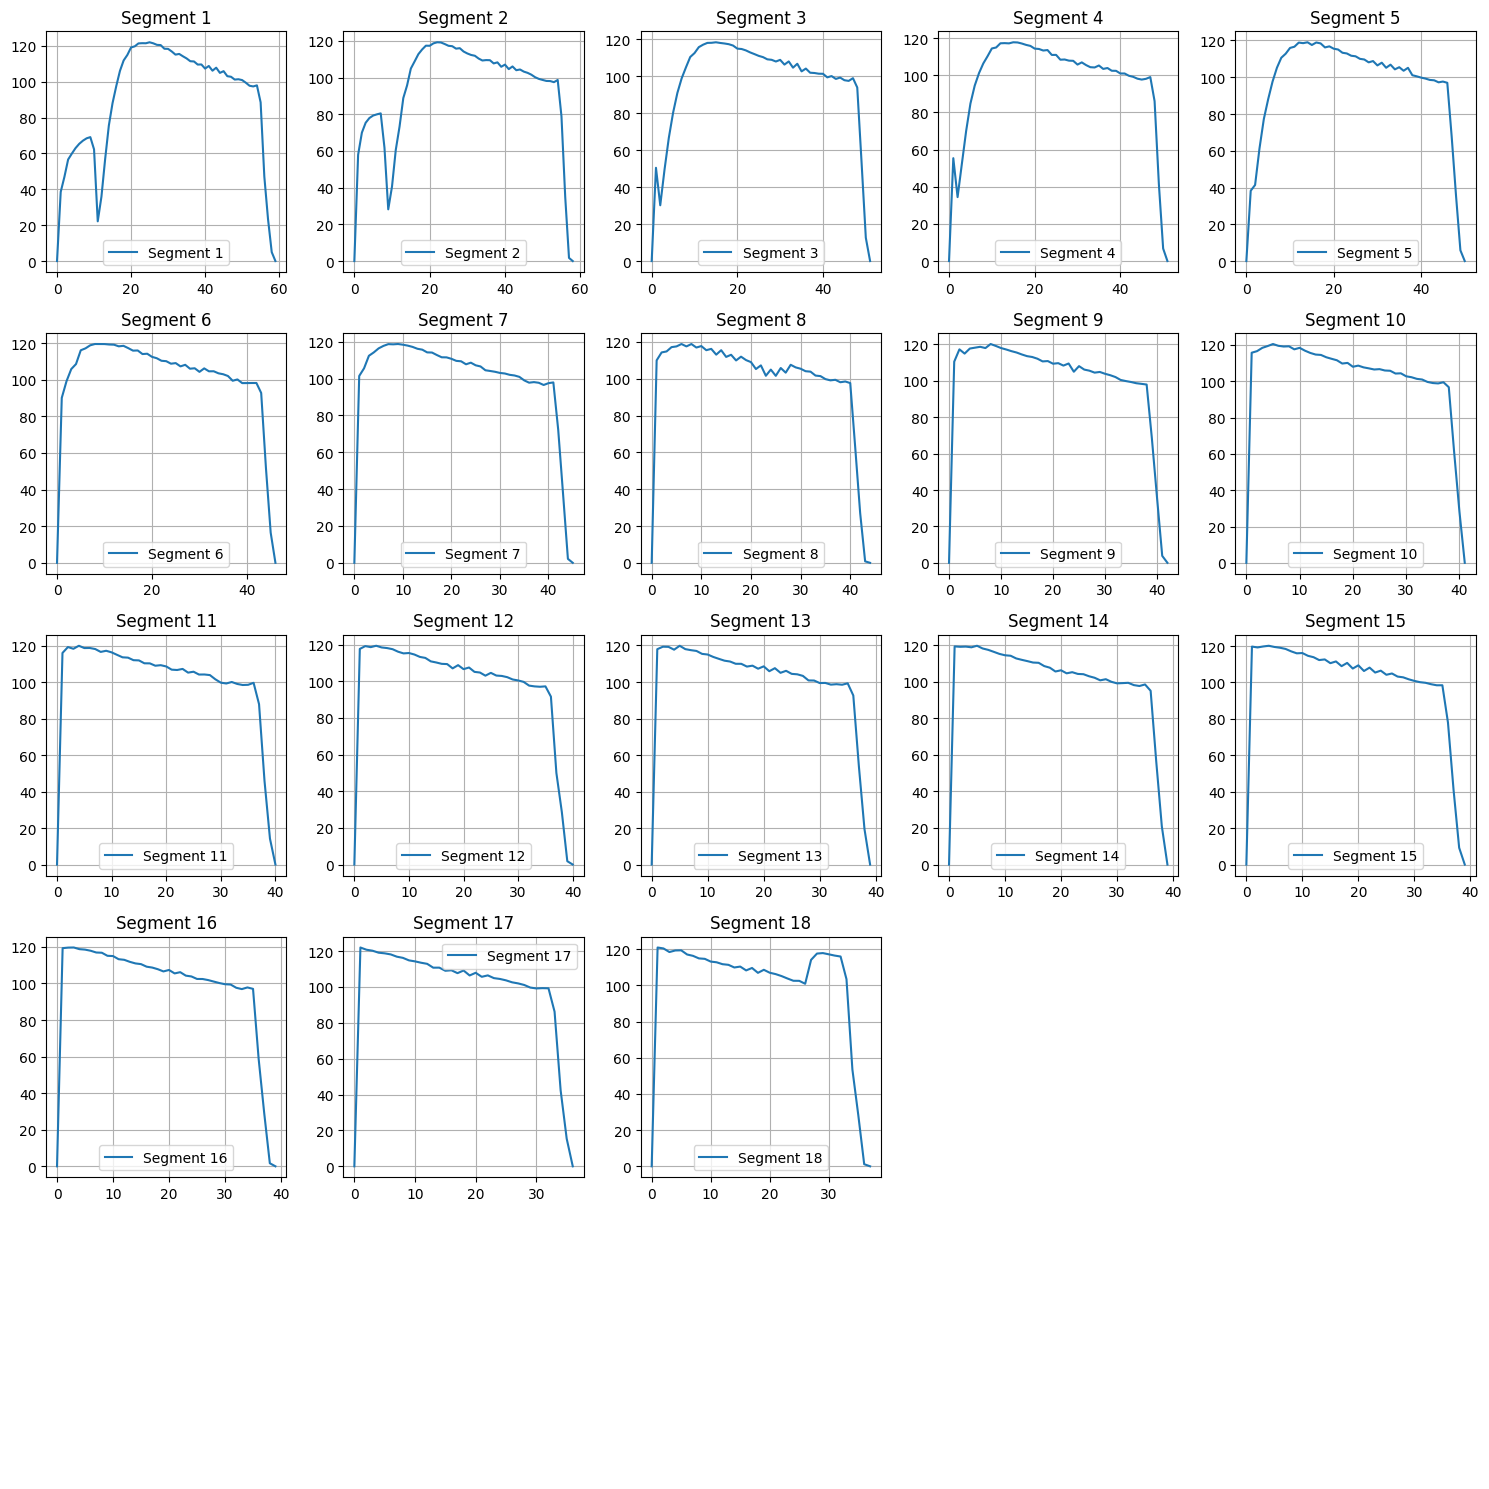

In [31]:
# Calculate the number of rows and columns for the subplot grid
import math
num_segments = len(non_zero_segments)
grid_size = math.ceil(math.sqrt(num_segments))  # n x n grid

# Create the subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through the segments and plot each one
for i, segment in enumerate(non_zero_segments):

    axes[i].plot(segment, label=f"Segment {i + 1}")
    axes[i].set_title(f"Segment {i + 1}")
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(num_segments, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


# Step 2: Perform Discrete Wavelet Decomposition
signal = non_zero_segments[2]  # Use the first segment for decomposition
wavelet = 'db4'
max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
# max_level = 5
coeffs = pywt.wavedec(signal, wavelet, level=max_level)



# Step 3: Reconstruct detail coefficients at each level
details = []
for i in range(1, len(coeffs)):
    coeff_list = [np.zeros_like(c) if j != i else coeffs[j] for j, c in enumerate(coeffs)]
    detail = pywt.waverec(coeff_list, wavelet)
    details.append(np.abs(detail[:len(signal)]))  # Ensure equal length

# Convert to 2D array for scalogram-like display
scalogram_array = np.vstack(details)



# Step 4: Plot the pseudo-scalogram
plt.figure(figsize=(5, 3))
extent = [t[0], t[-1], 1, len(details)]
plt.imshow(scalogram_array, extent=extent, aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('Pseudo-Scalogram from Discrete Wavelet Decomposition', fontsize=8)
plt.xlabel('Time [s]')
plt.ylabel('Decomposition Level')
plt.yticks(ticks=np.arange(1, len(details)+1), labels=[f'D{len(details)-i}' for i in range(len(details))])
plt.tight_layout()
plt.show()


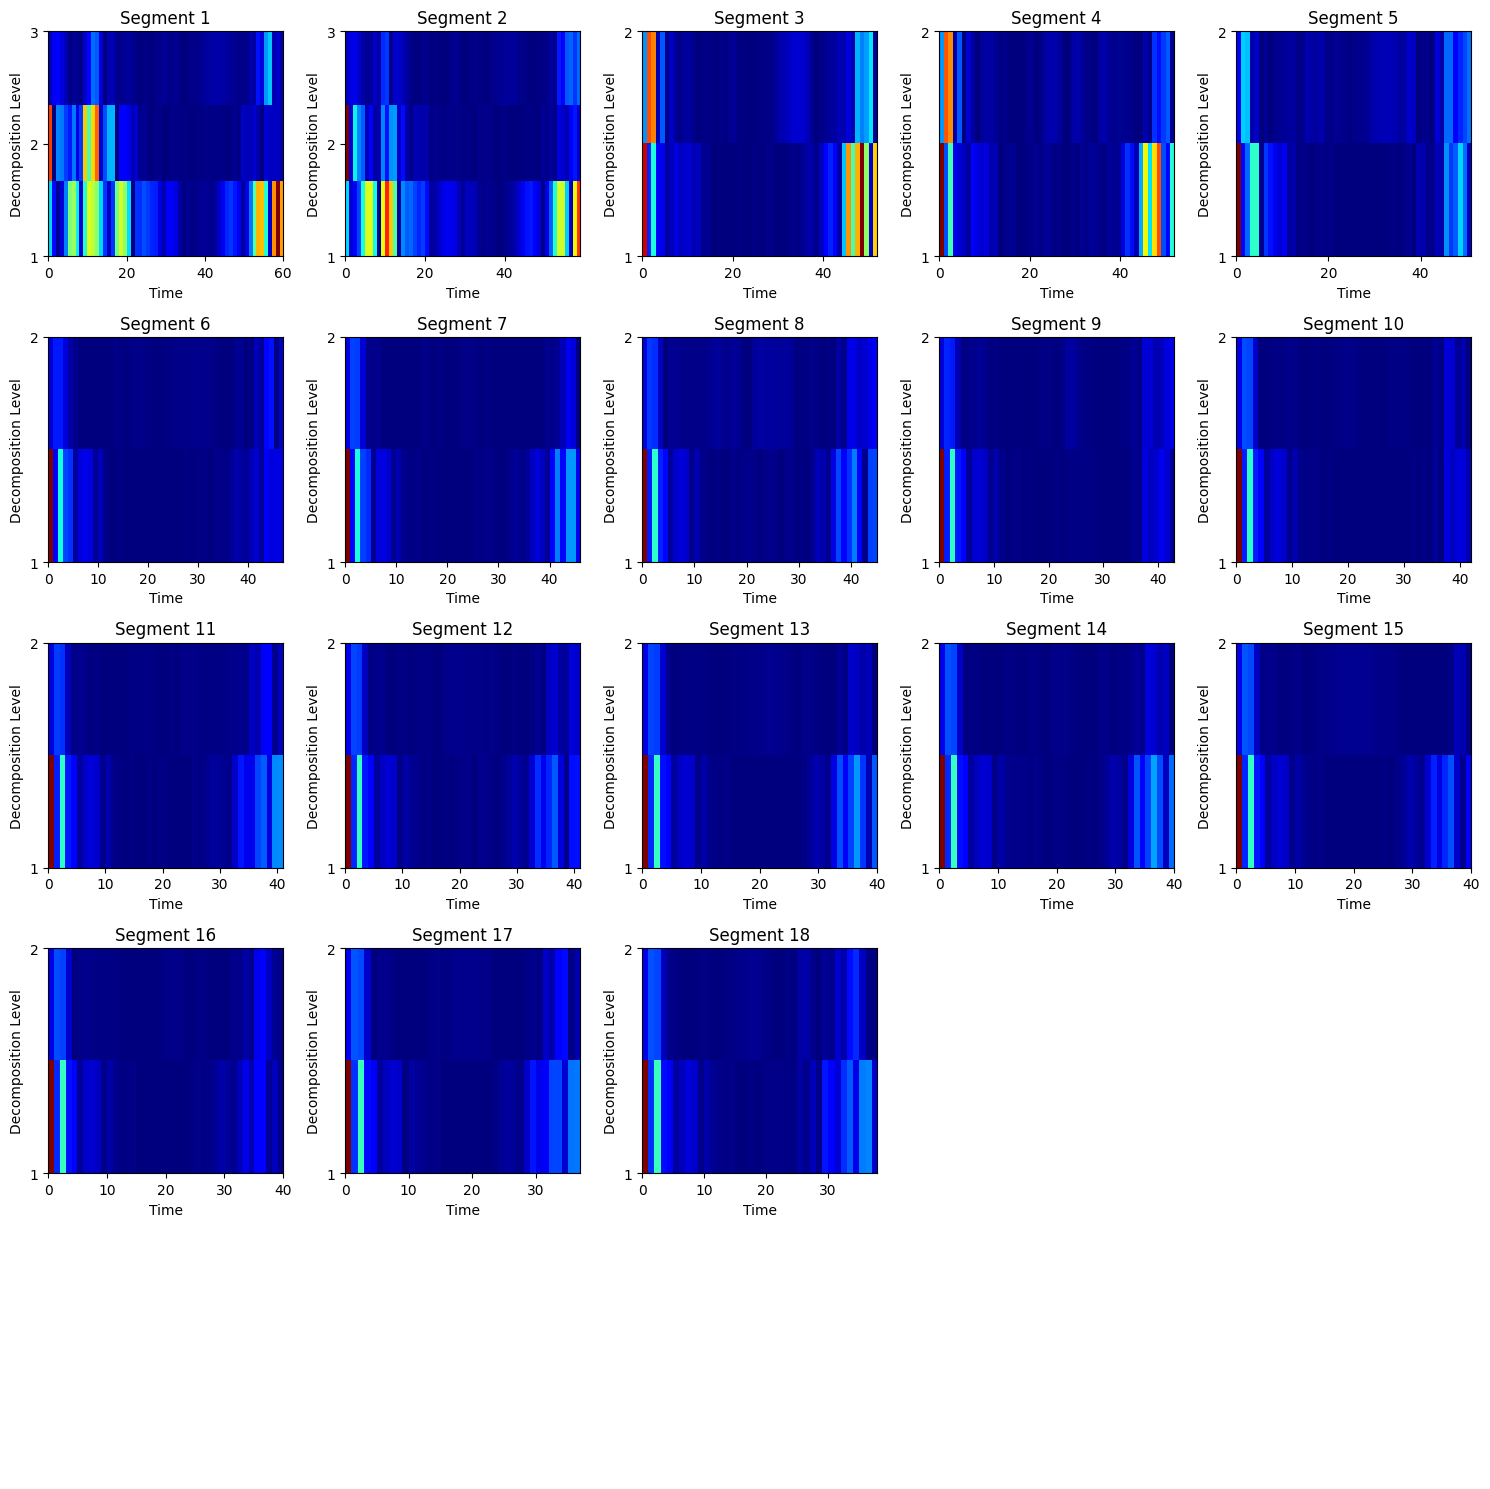

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import math

# Assuming non_zero_segments is already defined
# non_zero_segments = [...]  # Replace with your actual data

# Parameters for wavelet analysis
wavelet = 'db4'

# Perform wavelet analysis on each segment
wavelet_results = []
for segment in non_zero_segments:
    # Perform Discrete Wavelet Decomposition
    max_level = pywt.dwt_max_level(len(segment), pywt.Wavelet(wavelet).dec_len)
    coeffs = pywt.wavedec(segment, wavelet, level=max_level)

    # Reconstruct detail coefficients at each level
    details = []
    for i in range(1, len(coeffs)):
        coeff_list = [np.zeros_like(c) if j != i else coeffs[j] for j, c in enumerate(coeffs)]
        detail = pywt.waverec(coeff_list, wavelet)
        details.append(np.abs(detail[:len(segment)]))  # Ensure equal length
    wavelet_results.append(np.vstack(details))  # Store the scalogram-like array

# Plot the wavelet results in an n x n grid
num_segments = len(wavelet_results)
grid_size = math.ceil(math.sqrt(num_segments))  # Calculate grid size

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through the wavelet results and plot each one
for i, scalogram_array in enumerate(wavelet_results):
    extent = [0, len(non_zero_segments[i]), 1, scalogram_array.shape[0]]
    axes[i].imshow(scalogram_array, extent=extent, aspect='auto', cmap='jet', origin='lower')
    axes[i].set_title(f"Segment {i + 1}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Decomposition Level')
    axes[i].set_yticks(np.arange(1, scalogram_array.shape[0] + 1))  # Set integer y-ticks


# Hide any unused subplots
for j in range(num_segments, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [28]:
print((wavelet_results[17].shape))

(2, 38)
